# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Наша задача — установить параметры, которые позволят построить автоматизированную систему. Данаая система сможет отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Загрузка данных и подготовка их к анализу

**Импортируем библиотеку pandas. Считываем данные из csv-файла в датафрейм и сохраняем в переменную data. 
Выводим первые 20 строчек датафрейма data на экран.
Импортируем библиотеку matplotlib для дальнейшей предобработки данных.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Изучаем общую информацию о датафрейме data с помощью метода info()

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

## Предобработка данных

### Удаление пропусков

**Изучаем пропущенные значения в столбцах. Определяем, в каких столбцах есть пропуски, и их количество.**

In [4]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**В тринадцати столбцах обнаружены пропущенные значения. Пропуски в столбце `ceiling_height`заполним медианным значением высоты потолков по районам после исправления ошибок с разрядностью после обработки аномальных значений**

**Пропуски в столбце `floors_total` удаляем, так как их небольшое количество, и они не повлиют на конечный результат.**

In [5]:
data = data.dropna(subset = ['floors_total'])

**Пропуски в столбце `living_area` заполним медианным значением жилой площади по количеству комнат.**

In [6]:
for t in data['rooms'].unique():
    data.loc[(data['rooms'] == t) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['rooms'] == t), 'living_area'].median()


**Пропуски в столбце `is_apartment` заменим на False. Мы предполагаем, что если в столбце `is_apatment` пропуск, это означает, что это не апартаменты.**

In [7]:
data['is_apartment'] = data['is_apartment'].fillna(False)


**Пропуски в стобце `kitchen_area`заполним медианным значением площади кухни по общей площади квартиры.**

In [8]:
for t in data['total_area'].unique():
    data.loc[(data['total_area'] == t) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
    data.loc[(data['total_area'] == t), 'kitchen_area'].median()


**Пропуски в столбце `balcony` означают, что скорее всего в квартире нет балкона, поэтому заполним пропуски 0.**

In [9]:
data['balcony'] = data['balcony'].fillna(0)

**Пропуски в столбце `locality_name` удаляем, так как их небольшое количество, и они не повлиют на конечный результат.**

In [10]:
data = data.dropna(subset = ['locality_name'])

Пропуски в столбцах `airports_nearest`,`cityCenters_nearest`,`parks_around3000`,`parks_nearest`,`ponds_around3000`,
`ponds_nearest`являются картографическими данными, которые должны автоматически добавляться при указании адреса в объявлении. 
Возможно, произошёл технический сбой, и эти данные не загрузились. Рекомендация: наладить получение картографических данных.
Пропуски в столбце `days_exposition` могут быть связаны с тем, что объявление о продаже квартиры всё ещё остается на сайте, поэтому количество дней размещения неизвестно.

**Проверяем пропущенные значения в столбцах после заполнения и удаления пропусков.**

In [11]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9084
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area              185
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64

### Изменение типов данных

**Находим столбцы, в которых нужно изменить тип данных. К таким столбцам относятся `floors_total`,`balcony`.
В данных столбцах тип данных float64. Меняем тип данных float64 на int64, так как общее количество этажей в доме и балконов в квартире всегда будут целыми числами.**

In [12]:
data['floors_total'] = data['floors_total'].astype(int)

In [13]:
data['balcony'] = data['balcony'].astype(int)

**Также необходимо изменить тип данных в столбце `first_day_exposition` с object на datetime, так как в этом столбце находится дата публикации.**

In [14]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        14481 non-null  float64       
 6   floors_total          23565 non-null  int32         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23380 non-null  float64       
 13  balcony         

#### Обработка дубликатов

**Обрабатываем неявные дубликаты в столбце `locality_name`. В этом столбце есть одни и те же значения, но записанные по-разному(поселок, посёлок). Для этого изучим уникальные значения в данном столбце.**


In [16]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [17]:
duplicates = ['поселок', 'поселок городского типа', 'посёлок городского типа','городской посёлок','коттеджный поселок'] # список неправильных имён
name = 'посёлок' # правильное имя
for duplicate in duplicates:
    data['locality_name'] = data['locality_name'].str.replace(duplicate, name) # замена всех значений из duplicates на name


Посмотрим на результат после обработки неявных дубликатов.

In [18]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'посёлок Красный Бор', 'Гатчина', 'деревня Фёдоровское', 'Выборг',
       'Кронштадт', 'Кировск', 'деревня Новое Девяткино',
       'посёлок Металлострой', 'посёлок Лебяжье', 'посёлок Сиверский',
       'посёлок Молодцово', 'посёлок Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'посёлок Ефимовский', 'посёлок Плодовое', 'деревня Заклинье',
       'посёлок Торковичи', 'посёлок Первомайское', 'Красное Село',
       'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'посёлок Новый Свет', 'Сланцы',
       'село Путилово', 'Ивангород', 'Мурино', 'Шлиссельбург',
       'Никольское', 'Зелено

### Устранение редких и выбивающихся значений (аномалий)

**Используем метод describe() для получения характеристик, дающих представление о столбцах датафрейма.**

In [19]:
data.shape

(23565, 22)

In [20]:
data.describe()


,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23565.000000,2.356500e+04,23565.000000,23565.000000,14481.000000,23565.000000,23565.000000,23565.000000,23380.000000,23565.000000,18041.000000,18064.000000,18065.000000,8030.000000,18065.000000,9036.000000,20394.000000
mean,9.878421,6.540058e+06,60.322824,2.070656,2.771283,10.675875,34.324326,5.878124,10.450498,0.593677,28797.082701,14192.656056,0.611569,490.580448,0.769499,518.289509,180.741395
std,5.681156,1.091093e+07,35.657060,1.078591,1.261983,6.594823,21.721235,4.871485,5.780881,0.960660,12632.499735,8613.348153,0.802088,341.572956,0.938669,278.009558,219.732782
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.510000,5.000000,18.400000,2.000000,7.000000,0.000000,18565.000000,9238.000000,0.000000,288.000000,0.000000,293.000000,45.000000
50%,9.000000,4.646000e+06,52.000000,2.000000,2.650000,9.000000,30.300000,4.000000,9.000000,0.000000,26757.000000,13096.500000,0.000000,455.000000,1.000000,503.000000,95.000000
75%,14.000000,6.790000e+06,69.700000,3.000000,2.800000,16.000000,42.700000,8.000000,11.800000,1.000000,37273.000000,16285.000000,1.000000,612.000000,1.000000,730.000000,231.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Для выявления редких и выбивающихся значений построим диаграммы размаха для каждого столбца таблицы

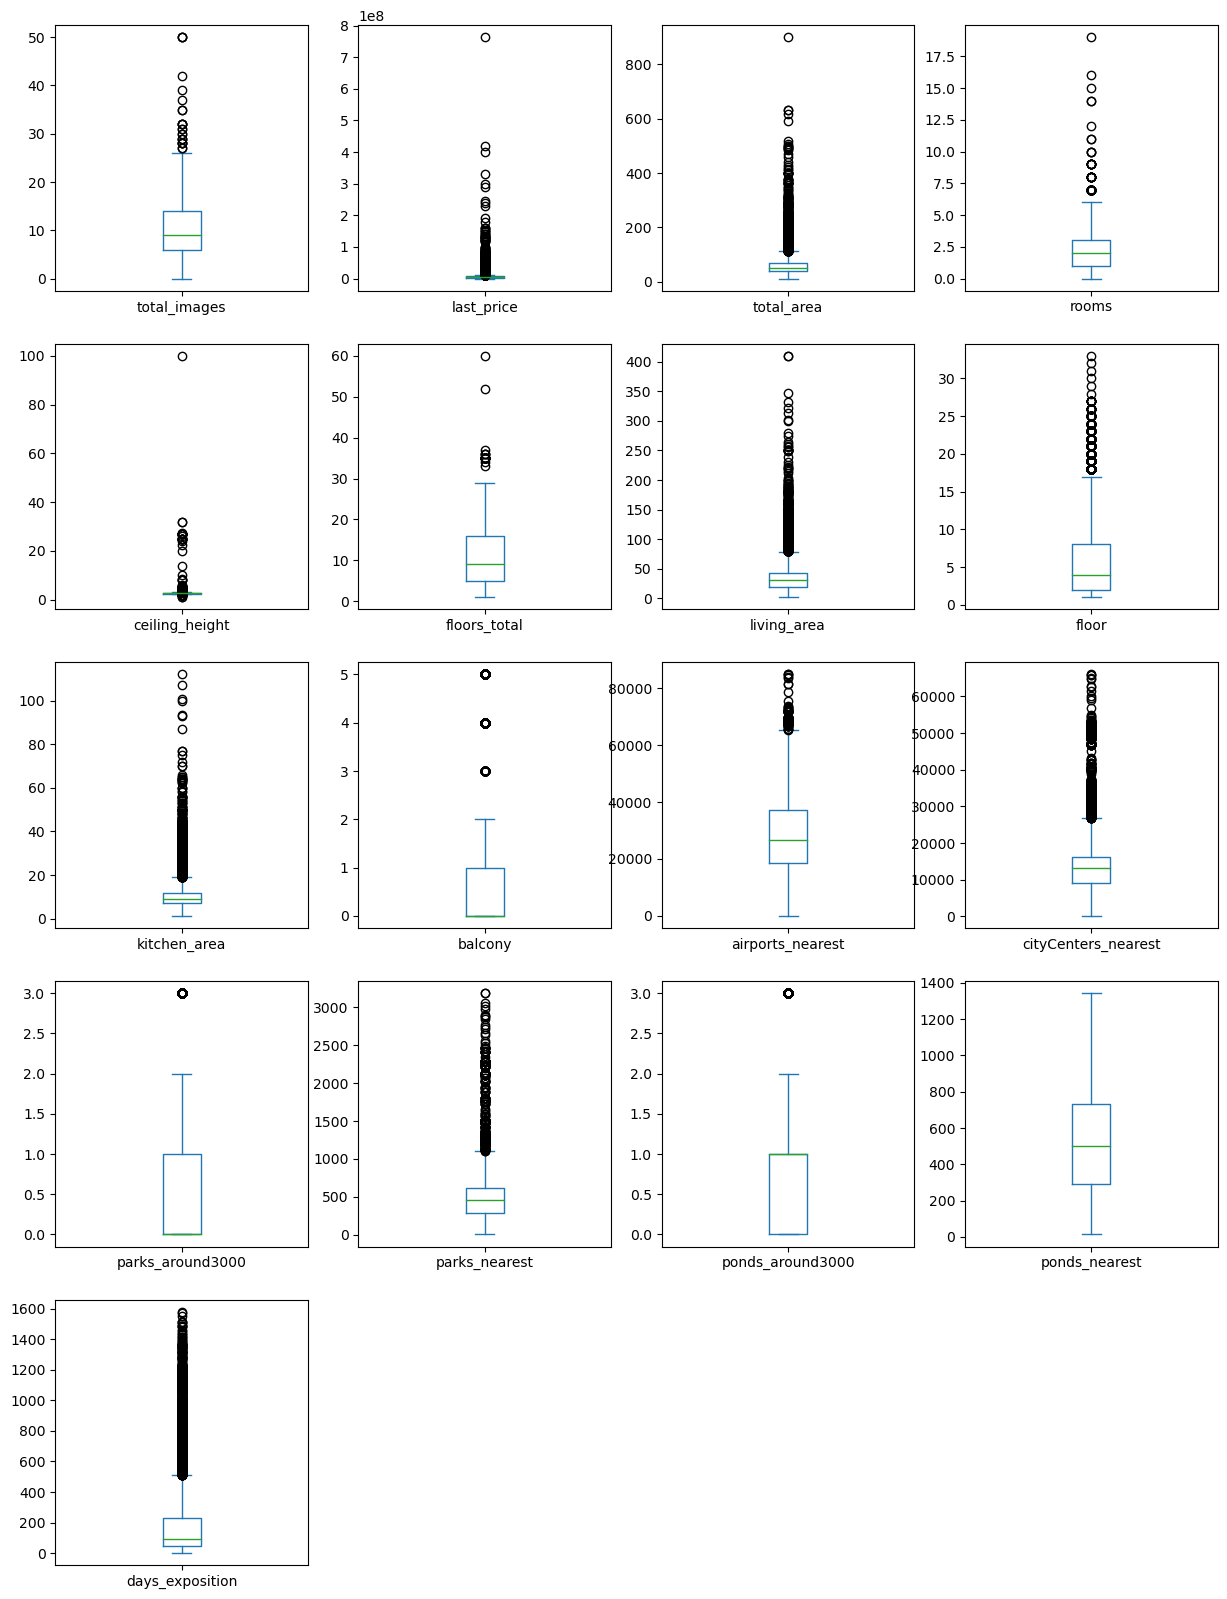

In [21]:
data.plot(kind='box', subplots=True, layout=(5,4), figsize=(15, 20));

Удалим аномальные значения цены квартиры менее 1500000, так как стоимость даже маленькой студии ниже 1500000 выглядит нереальной.

In [22]:
data = data.query('last_price >= 1500000')

Удаляем значения в столбце `total_area` менее 18 м²,так как они являются аномальными. Минимальная площадь студии в Питере должна составлять 18м².

In [23]:
data = data.query('total_area >= 18')

Количество комнат более 7 является довольно редким явлением, однако этот показатель непосредственно влияет на стоимость квартиры, поэтому удалим аномалии.

In [24]:
data = data.query('rooms <= 7')

В столбце `ceiling_height` есть аномально большие значения высоты потолков. Логично предположить, что вместо 25м  или 32м в данных должны быть вещественные значения 2.5м и 3.2м. Чтобы исправить данную аномалию используем метод where(), чтобы изменить значения высоты потолков, которые привышают 20м. Затем построим диаграмму размаха.

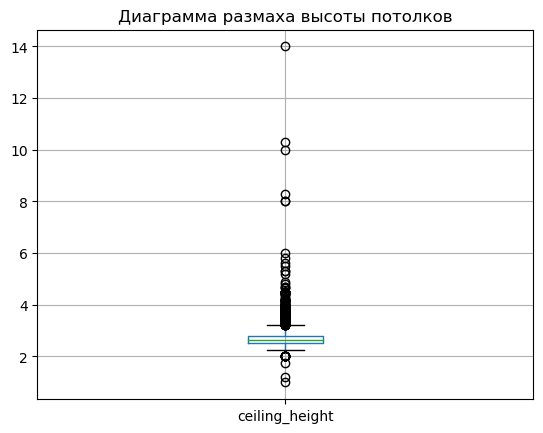

In [25]:
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height'] < 20, data['ceiling_height']/10)

data.boxplot(column = 'ceiling_height')
plt.title('Диаграмма размаха высоты потолков')
plt.show()

Мы видим, что основная часть значений в столбце `ceiling_height` составляет до 6м, высота потолков 8,10 и 14 метров являются аномальными значениями, поэтому мы их удалим. Также аномальными значениями явяляется высота потолка до 2.4м, так как это минимальная высота потолка для жилого помещения.

In [26]:
data = data.query('2.4 <= ceiling_height <= 6')


Пропуски в столбце `ceiling_height`заполним медианным значением высоты потолков по районам.

In [27]:
for i in data['locality_name'].unique():
    data.loc[(data['locality_name'] == i) & (data['ceiling_height'].isna()), 'ceiling_height'] = \
    data.loc[(data['locality_name'] == i), 'ceiling_height'].median()


Проверим наличие пропусков в столбцах ещё раз

In [28]:
data.isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area              58
balcony                    0
locality_name              0
airports_nearest        2637
cityCenters_nearest     2617
parks_around3000        2616
parks_nearest           8855
ponds_around3000        2616
ponds_nearest           8417
days_exposition         2364
dtype: int64

Удалим жилую площадь менее 12 м², так как меньшие значения выглядят нереалистичными. Даже в самой маленькой студии (18 м²) жилая площадь не может быть менее 12 м².

In [29]:
data = data.query('living_area >= 12')

Удалим значения в столбце `kitchen_area` менее 4 м², так как даже в самой маленькой студии площади кухни начинается от 4 м².

In [30]:
data = data.query('kitchen_area >= 4')

Расстояние до аэропорта равное 0 является аномальным, так как жилое помещение не может находится на территории аэропорта.

In [31]:
data = data.query('airports_nearest != 0')

Мы проанализировали диаграммы размаха по всем столбцам таблицы и пришли к выводу, что необходимо устранить выбивающиеся и редкие значения в следующих столбцах: `last_price`,`total_area`,`living_area`,`airports_nearest`,`kitchen_area`,`rooms`,`ceiling_height`, так как в данных столбцах были выявлены аномальные значения, которые в ходе исследования могут привести к искажению результатов работы.

In [32]:
data.shape

(13968, 22)

### Добавление новых столбцов в таблицу

Добавим в таблицу новый столбец с ценой за один квадратный метр, для этого разделим общую стоимость квартиры на её общую площадь.

In [33]:
data['price_per_square_meter'] = data['last_price']/data['total_area']

Добавим в таблицу новый столюец с днем недели, когда было опубликовано объявление.

In [34]:
data['weekday'] = data['first_day_exposition'].dt.weekday

Добавим новый столбец с месяцем публикации объявления.

In [35]:
data['month'] = data['first_day_exposition'].dt.month

Добавим новый столбец с годом публикации объявления.

In [36]:
data['year'] = data['first_day_exposition'].dt.year

Добавим в таблицу новый столбец с типом этажа квартиры(первый, последний, другой), для этого напишем функцию.

In [37]:
def categorise_floor (row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'
    
data['floor_type'] = data.apply(categorise_floor,axis=1)
    

Добавим столбец с расстоянием до центра города в км, округлим до целых значений.

In [38]:
data['cityCenters_distance'] = data['cityCenters_nearest']/1000
data['cityCenters_distance'] = data['cityCenters_distance'].round(0)

Выведем первые 5 строк датафрейма на экран, чтобы проверить, что все столбцы добавились правильно.

In [39]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday,month,year,floor_type,cityCenters_distance
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой,16.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,другой,8.0
9,18,5400000.0,61.0,2017-02-26,3,2.50,9,43.6,7,False,...,NaN,0.0,NaN,289.0,88524.590164,6,2,2017,другой,15.0
10,5,5050000.0,39.6,2017-11-16,1,2.67,12,20.3,3,False,...,310.0,2.0,553.0,137.0,127525.252525,3,11,2017,другой,14.0
13,20,3550000.0,42.8,2017-07-01,2,2.56,5,27.0,5,False,...,294.0,3.0,298.0,366.0,82943.925234,5,7,2017,последний,33.0


## Исследовательский анализ данных

### Изучение параметров объектов

**Для изучения параметров объектов построим графики для определенных столбцов таблицы и опишем наши наблюдения.**

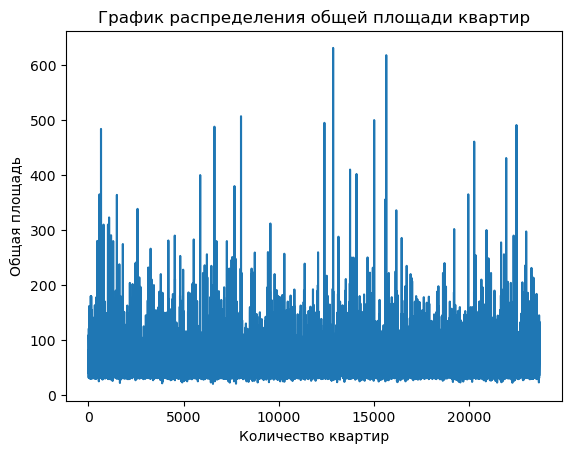

In [40]:
data['total_area'].plot(title='total_area',kind='line')
plt.title('График распределения общей площади квартир')
plt.xlabel('Количество квартир')
plt.ylabel('Общая площадь')
plt.show()

По данному графику мы видим, что бОльшая часть квартир имеют общую площадь от 35 м² до 120 м². Данные выглядят достоверными, поскольку чаще всего в объявлениях о продаже встречаются квартиры именно с такой площадью, так как они обычно являются оптимальными по цене и по площади для покупки семьями. Квартиры менее 35 м² встречаются реже, скорее всего это студии. Такой вид жилья не пользуется таким же большим спросом, так как он не подходит для семей. Максимальная общая площадь квартир составляет более 600 м², таких квартир немного, но они есть.

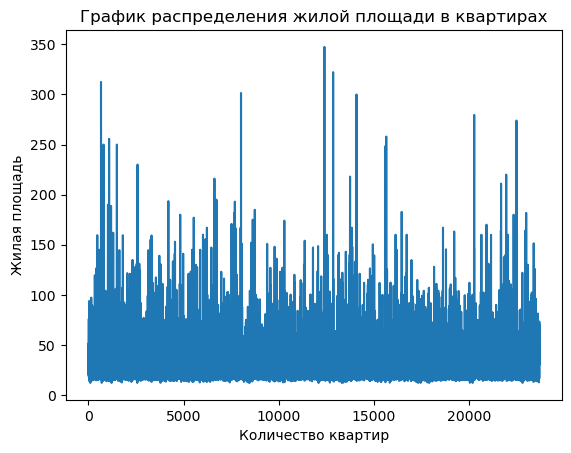

In [41]:
data['living_area'].plot(title='living_area',kind='line')
plt.title('График распределения жилой площади в квартирах')
plt.xlabel('Количество квартир')
plt.ylabel('Жилая площадь')
plt.show()

На графике мы видим, что чаще всего жилая площадь в квартирах составляет от 20 до 75 м². Минимальная жилая площадь 12 м² встречается редко, так как такая жилая площадь может быть в очень маленькой студии. Такое жилье не пользуется спросом, поскольку подходит для 1 человека на недолгий период времени. Максимальные значения жилой площади достигают 350 м², но также являются довольно редкими, поскольку квартир с такой площадью не так много. В силу своей стоимости немногие могут позволить себе приобретение такого жилья.

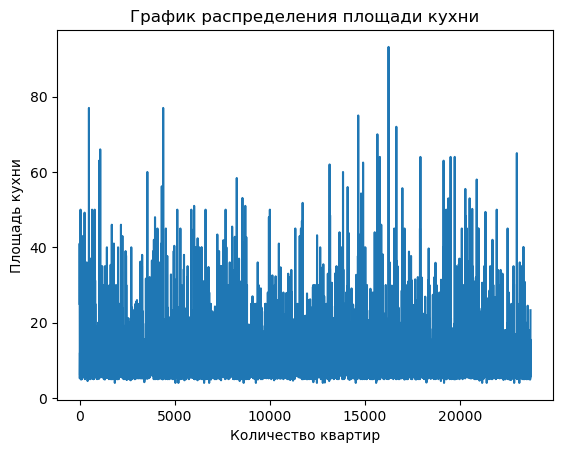

In [42]:
data['kitchen_area'].plot(title='kitchen_area',kind='line')
plt.title('График распределения площади кухни')
plt.xlabel('Количество квартир')
plt.ylabel('Площадь кухни')
plt.show()

Показатели площади кухни являются аналогичными показателям общей и жилой площади. Чаще всего площадь кухни составляет от 7 до 20 м². Эти данные выглядят достоверными, так как именно такой размер кухонь характерен для квартир с площадями от 35 м² до 120 м². Минимальный размер кухни составляет 4 м², такие кухни характерны для студий(если учитывать кухню без гостинной) и малогаборитных квартир. Довольно редкими явялются значения выше 60 м², так как такие кухни могут быть только в квартирах с довольно большой общей площадью. Как мы выяснили, такие объявления встречаются не очень часто.

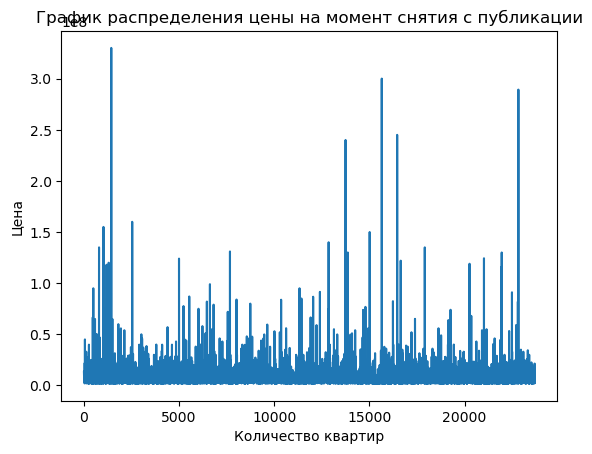

In [43]:
data['last_price'].plot(title='last_price',kind='line')
plt.title('График распределения цены на момент снятия с публикации')
plt.xlabel('Количество квартир')
plt.ylabel('Цена')
plt.show()

Минимальные значения цены квартиры на момент снятия с публикации начинаются от 1500000 рублей, так может стоить маленькая студия в соседнем к Санкт-Петербургу населенном пункте. В среднем стоимость квартир состаляет от 4.5 до 8 миллинов рублей. Именно так стоят квартиры в Санкт-Петербурге и пригороде. Максимальная стоимость составляет 763000000. Мы изучили объявления на площадках о продаже жилья и такая цена за квартиру 600 м² выглядит вполне реальной.

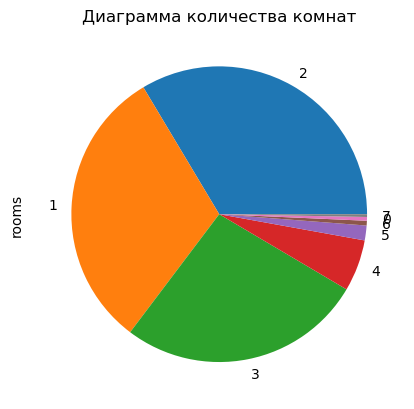

In [44]:
data['rooms'].value_counts().plot(kind='pie')
plt.title('Диаграмма количества комнат')
plt.show()

На круговой диаграмме мы видим, что в основном продаются 1-комнатные и 2-комнатные квартиры, немного меньше продается 3-комнатных квартир, но их доля также довольно большая. Эти данные выглядят достоверными, так как именно такие квартиры являются самыми распространенными. Меньше всего продается 6 и 7-комнатных квартир, так как такие квартиры встречаются довольно редко и имеют большую общую и жилую площадь. С помощью предыдущих диаграмм мы выяснили,что квартир с огромной площадью не так уж и много. 

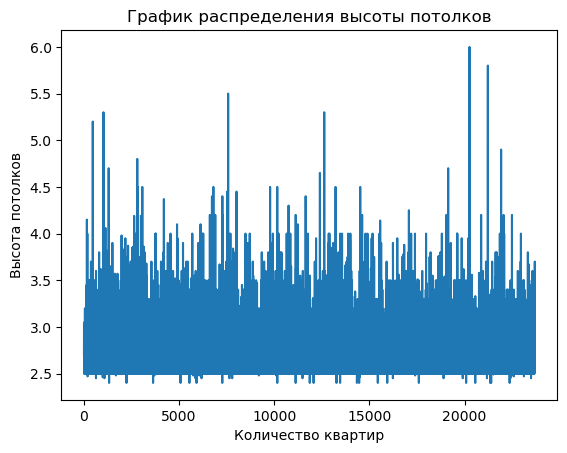

In [45]:
data['ceiling_height'].plot(title='ceiling_height',kind='line')
plt.title('График распределения высоты потолков')
plt.xlabel('Количество квартир')
plt.ylabel('Высота потолков')
plt.show()

В среднем высота потолков составляет 2.7 м. Такая высота потолков считается стандартной и встречается чаще всего. Есть несколько квартир с потолками от 2.4 до 2.7 м, но это довольно редкие случаи. Самые большая высота потолков достигает 6м, но также встречается не часто. 

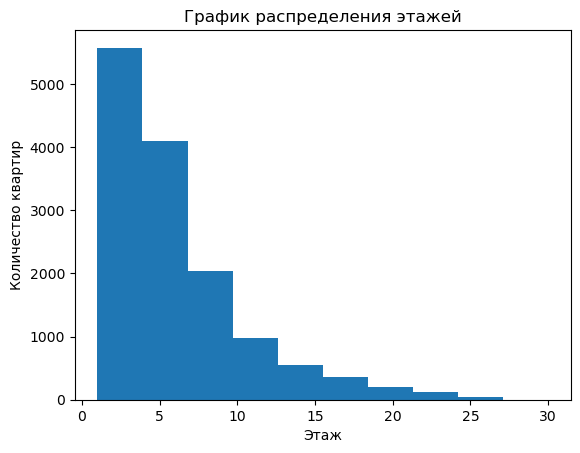

In [46]:
data['floor'].plot(title='floor',kind='hist')
plt.title('График распределения этажей')
plt.xlabel('Этаж')
plt.ylabel('Количество квартир')
plt.show()

На гистограмме мы видим, что самые часто встречающиеся этажи в проданных квартирах - с 1 по 4. Квартир на 5-ом этаже меньше. Это можно обосновать тем, что большое количество жилья продавалось в том числе в старой 5-этажной застройке. Обычно люди менее охотно покупают жилье на последнем этаже, особенно в старых домах, так как квартиры на последних этажах могут иметь непредвиденные проблемы (например, проблемы с крышей). Чем выше этаж, тем меньше квартир представлено. Причина заключается в том, что на данный момент большая часть застройки в Питере и пригороде относится к старому жилищному фонду, который обычно имеет не более 9-ти этажей.

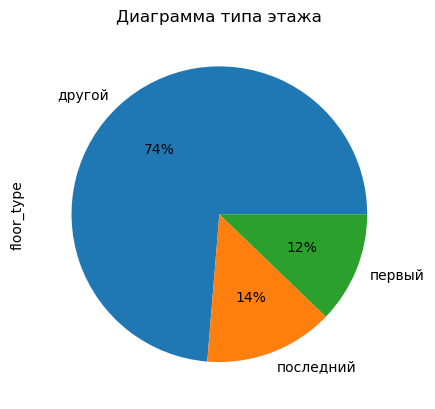

In [47]:
data['floor_type'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Диаграмма типа этажа')
plt.show()

Доля проданных квартир на 1-ом и последнем этажах примерно одинаковая. Это объясняется тем, что на этих этажах люди менее охотно покупают недвижимость. На последнем этаже могут быть проблемы с крышей или неудобство при отсутствии лифта, а на первом неприятный запах из подвала, близость кафе или магазинов (в которых могут быть крысы или тараканы), шум с улицы, отсутствие балконов.

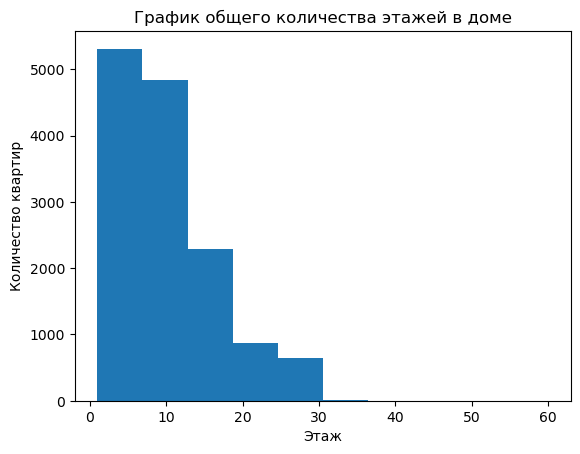

In [48]:
data['floors_total'].plot(title='floors_total',kind='hist')
plt.title('График общего количества этажей в доме')
plt.xlabel('Этаж')
plt.ylabel('Количество квартир')
plt.show()

На гистограмме мы видим, что большая часть жилья имеет до 9 этажей. Это можно обосновать тем, что в основном старый жилой фонд имеет такую этажность. Максимальное количество этажей в доме - 36. Такая этажность может быть в современных многоэтажках.

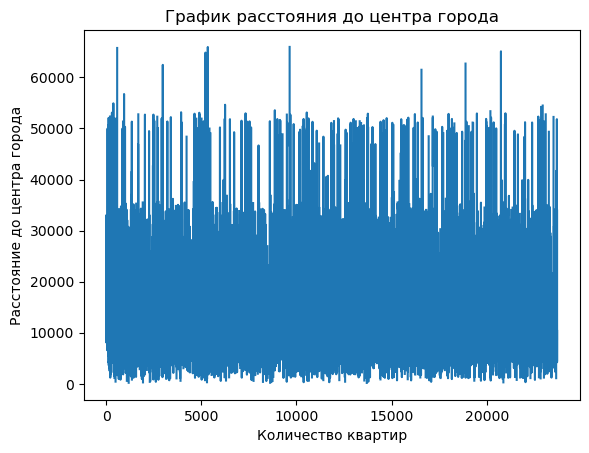

In [49]:
data['cityCenters_nearest'].plot(title='cityCenters_nearest',kind='line')
plt.title('График расстояния до центра города')
plt.xlabel('Количество квартир')
plt.ylabel('Расстояние до центра города')
plt.show()

В среднем расстояние до центра города от квартир составляет 15000м (15 км). Такое расстояние выглядит довольно реальным, если учитывать, что много квартир находятся в пригороде, но также есть квартиры рядом с центром. Например, минимальное расстояние до центра составляет 181 м, а максимальное 66000м (66км).

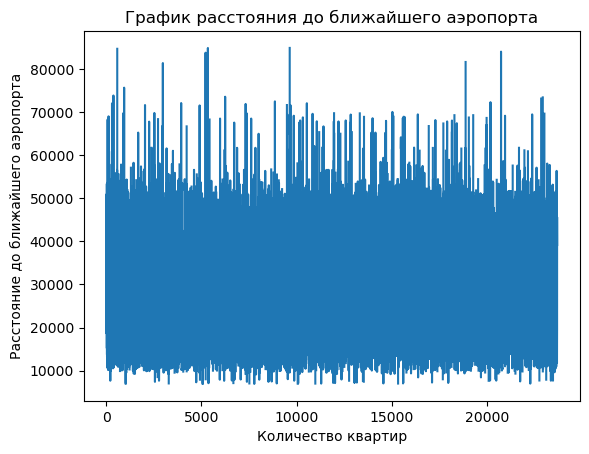

In [50]:
data['airports_nearest'].plot(title='airports_nearest',kind='line')
plt.title('График расстояния до ближайшего аэропорта')
plt.xlabel('Количество квартир')
plt.ylabel('Расстояние до ближайшего аэропорта')
plt.show()

На гистограмме видно, что в среднем расстояние до аэропорта составляет от 15000 до 50000м (15 до 50 км). Однако есть квартиры, которые расположены ближе, в 5-10 км, что может доставить определенные неудобства (например, шум). Некоторые квартиры находятся очень далеко от аэропорта, максимальное расстояние составляет 85000м(85км).

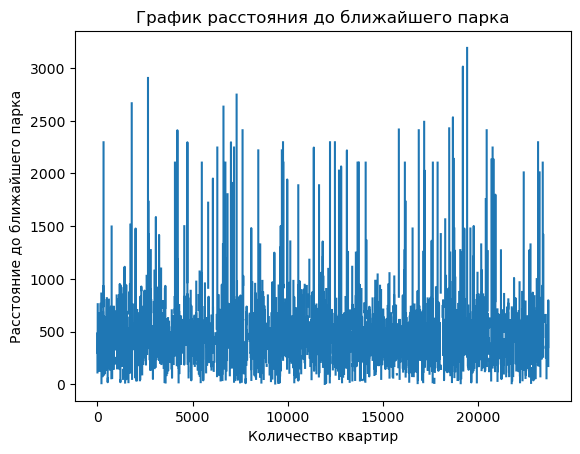

In [51]:
data['parks_nearest'].plot(title='parks_nearest',kind='line')
plt.title('График расстояния до ближайшего парка')
plt.xlabel('Количество квартир')
plt.ylabel('Расстояние до ближайшего парка')
plt.show()

В среднем квартиры находятся в 300-1000 м от парка, что является пешей доступностью. Большая доля квартир находится на расстоянии от 1000 до 2500м. Всего несколько квартир находятся в 3000 м от парка.

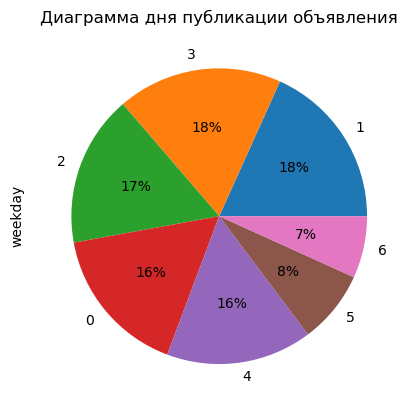

In [52]:
data['weekday'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Диаграмма дня публикации объявления')
plt.show()

На круговой диаграмме мы видим, что доля объявлений, опубликованных в будние дни (0-4), выше, чем в выходные (5-6). Это логично, так как в выходные дни люди отдыхают и меньше занимаются вопросами с недвижимостью.

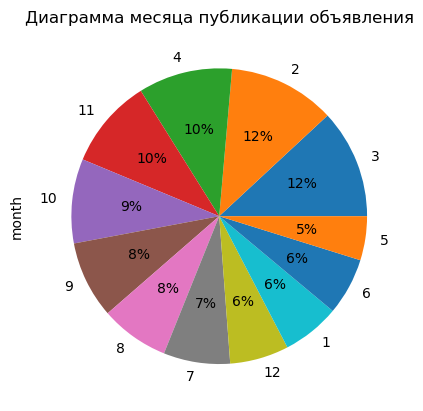

In [53]:
data['month'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Диаграмма месяца публикации объявления')
plt.show()

Самыми популярными месяцами для публикации объявлений о продаже квартиры являются октябрь, ноябрь, март, апрель, февраль. В эти месяцы нет долгих праздников или других сезонных событий. Менее популярные месяцы - декабрь (люди готовятся к праздникам) январь (зимние каникулы/праздники), май (майские праздники), все летние месяцы (так как многие уезжают на море, в деревню), сентябрь (начало учебного года).

### Изучение скорости продажи квартир

**Строим гистограмму для столбца `days_exposition`.**

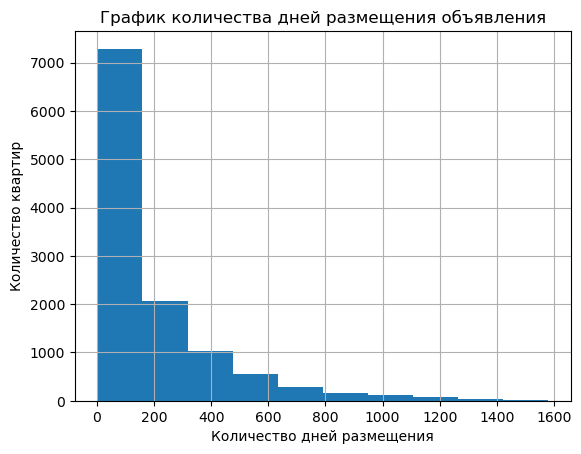

In [54]:
data['days_exposition'].plot(title='days_exposition',kind='hist',grid=True)
plt.title('График количества дней размещения объявления')
plt.xlabel('Количество дней размещения')
plt.ylabel('Количество квартир')
plt.show()

Считает среднее и медиану для столбца `days_exposition`.

In [55]:
days_exposition_mean = data['days_exposition'].mean()
days_exposition_mean

190.49453481366726

In [56]:
days_exposition_median = data['days_exposition'].median()
days_exposition_median

103.0

В среднем продажа квартиры занимает от 90 до 200 дней (от 3 до 6 месяцев). Продажи за месяц или полтора (30-45 дней) можно считать быстрыми, а продажи, которые длятся 3-4 года (1500 дней) можно считать очень долгими.

### Изучение факторов, вляющих на общую стоимость объекта

**Построим графики и опишем факторы, влияющие на общую стоимость объектов.**

Изучим график зависимости цены от общей площади квартиры.

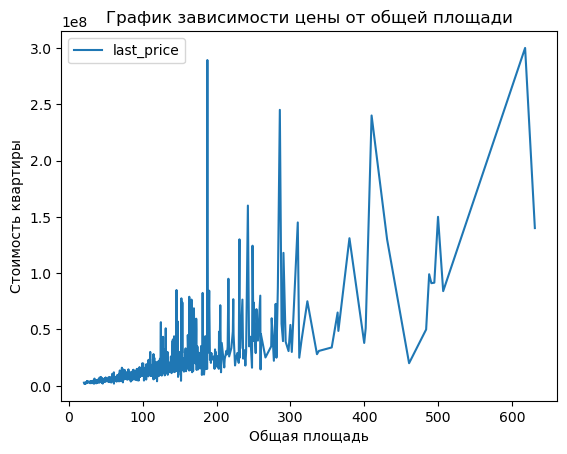

In [57]:
data.pivot_table(index='total_area',values='last_price').plot(title='График зависимости цены от общей площади')
plt.xlabel ('Общая площадь')
plt.ylabel ('Стоимость квартиры')
plt.show()

Рассмотрим величину корреляции с помощью коэффициента Пирсона. Корреляция составляет 0.6. Это говорит о наличии связи между данными параметрами.

In [58]:
data['total_area'].corr(data['last_price'])

0.6987561848132029

Корреляция 0.6 означает, что чем больше общая площадь квартиры, тем выше её стоимость. На графике мы видим особый пик на квартирах площадью 400 м². Пик может быть связан с тем, что это самая востребованная площадь квартир в данном сегменте. Также мы видим спад в цене у квартир с площадью 190 м². Возможно, дело в том, что такие квартиры уже не по карману для среднего класса покупателей, но в тоже время недостаточно просторные для высшего класса.

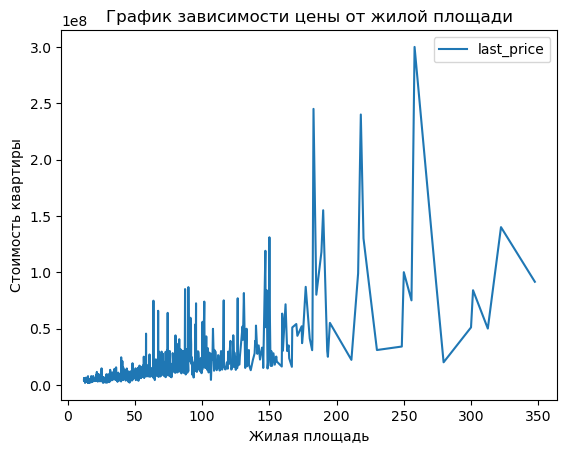

In [59]:
data.pivot_table(index='living_area',values='last_price').plot(title='График зависимости цены от жилой площади')
plt.xlabel ('Жилая площадь')
plt.ylabel ('Стоимость квартиры')
plt.show()

Рассмотрим величину корреляции с помощью коэффициента Пирсона. Корреляция составляет 0.5. Это говорит о наличии связи, но не слишком сильной.

In [60]:
data['living_area'].corr(data['last_price'])

0.5937742626688828

Корреляция 0.5 означает, что чем больше жилая площадь квартиры, тем выше её стоимость. На графике мы видим особый пик на квартирах площадью 200 м². Пик может быть связан с тем, что это самая востребованная площадь квартир в данном сегменте. Также мы видим спад в цене у квартир с площадью 250 м². 

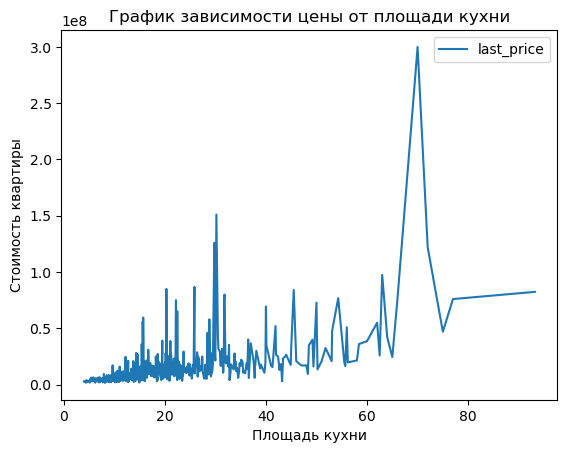

In [61]:
data.pivot_table(index='kitchen_area',values='last_price').plot(title='График зависимости цены от площади кухни')
plt.xlabel ('Площадь кухни')
plt.ylabel ('Стоимость квартиры')
plt.show()

Рассмотрим величину корреляции с помощью коэффициента Пирсона. Корреляция составляет 0.5. Это говорит о наличии связи, но не слишком сильной.

In [62]:
data['kitchen_area'].corr(data['last_price'])

0.5255471732443939

Корреляция 0.5 означает, что чем больше площадь кухни, тем выше стоимость квартиры. На графике мы видим особый пик на квартирах с площадью кухни 30 м² и 70 м². Скорее всего такие кухни-гостинные могут быть в квартирах 200 и 400 м² соответственно. Как мы выяснили по предыдущим факторам, именно квартиры с такой площадью пользуются спросом в высоком ценовом сегменте, отсюда и высокая стоимость.

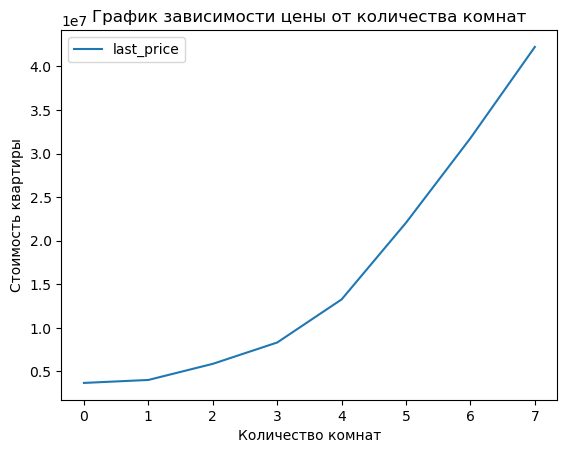

In [63]:
data.pivot_table(index='rooms',values='last_price').plot(title='График зависимости цены от количества комнат')
plt.xlabel ('Количество комнат')
plt.ylabel ('Стоимость квартиры')
plt.show()

Рассмотрим величину корреляции с помощью коэффициента Пирсона. Корреляция составляет 0.3. Связь с данным фактором довольно слабая.

In [64]:
data['rooms'].corr(data['last_price'])

0.38844315354622055

Корреляция 0.3 означает, что чем больше комнат в квартире, тем выше ее стоимость, однако связь с данным фактором не сильная. График соответсвует данному предположению.

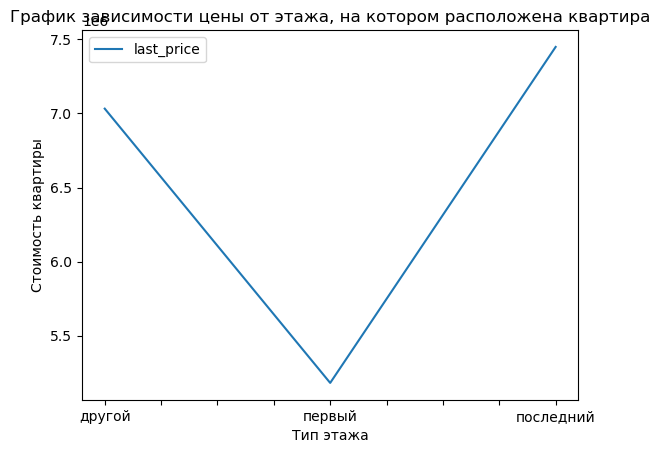

In [65]:
data.pivot_table(index='floor_type',values='last_price').plot(title='График зависимости цены от этажа, на котором расположена квартира')
plt.xlabel ('Тип этажа')
plt.ylabel ('Стоимость квартиры')
plt.show()

На графике мы видим, что самая низкая стоимость у квартир на 1-ом этаже, так как они являются не очень популярным вариантом для покупки по ряду причин: неприятный запах из подвала, близость кафе или магазинов (в которых могут быть крысы или тараканы), шум с улицы, отсутствие балконов.
Самая высокая стоимость наблюдается у квартир на последнем этаже. Это может быть связано с ценой на пентхаусы, которые находятся на последних этажах и обычно очень дорого стоят. Также в новостройках люди могут покупать жилье на последнем этаже, так как там может быть красивый вид.

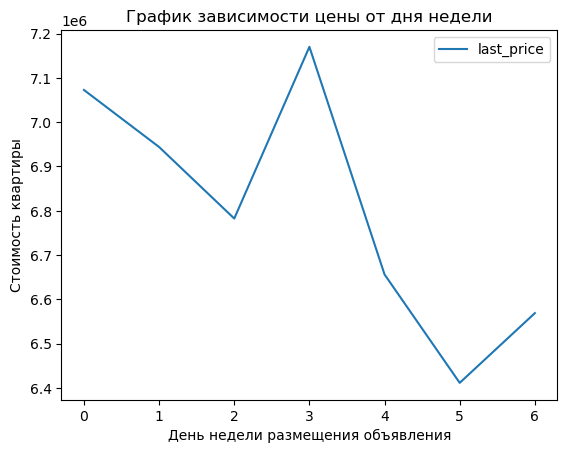

In [66]:
data.pivot_table(index='weekday',values='last_price').plot(title='График зависимости цены от дня недели')
plt.xlabel ('День недели размещения объявления')
plt.ylabel ('Стоимость квартиры')
plt.show()

На графике мы видим, что самая высокая стоимость у квартир, которые продаются по субботам. Возможно это связано с тем, что в выходной день люди более охотно идут на серьезные сделки, так как они в лучшем расположении духа. В пятницу наблюдается сильный спад в цене. Это может быть связано с тем, что в пятницу люди менее охотно идут на сделки из-за усталости.

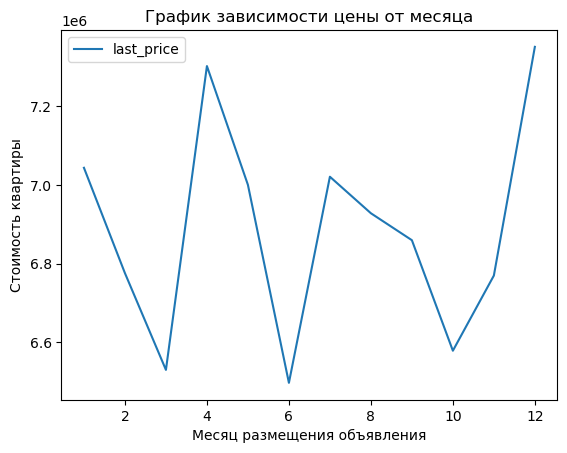

In [67]:
data.pivot_table(index='month',values='last_price').plot(title='График зависимости цены от месяца')
plt.xlabel ('Месяц размещения объявления')
plt.ylabel ('Стоимость квартиры')
plt.show()

Самая высокая цена наблюдается в апреле, сентябре и декабре. В январе, феврале, в летние месяцы и октябре наблюдается спад. Это может быть связано с различными сезонными событиями и праздниками.

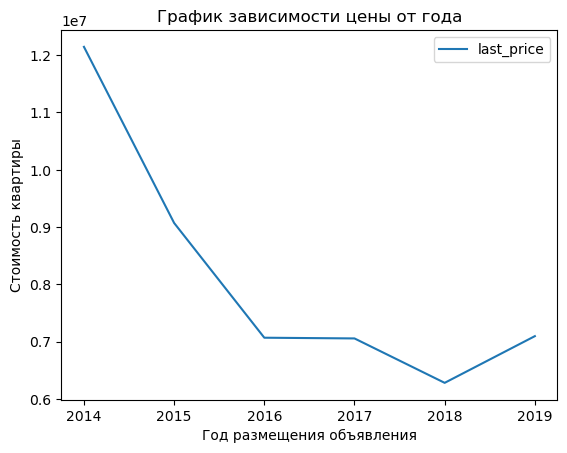

In [68]:
data.pivot_table(index='year',values='last_price').plot(title='График зависимости цены от года')
plt.xlabel ('Год размещения объявления')
plt.ylabel ('Стоимость квартиры')
plt.show()

По графику видно, что после 2014 года цены на жилье начали постепенно снижаться. Это произошло после вступления Крыма в Россию, а затем в 2018 году цены снова начали рости, возможно, после чемпиона мира по футболу, который прошёл в России.

### Расчет средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [69]:
top10_cities = data.pivot_table (index='locality_name',values=('last_price','price_per_square_meter'),aggfunc=('mean','count'))
top10_cities.columns = ['last_price','price_per_square_meter', 'last_price_need','last_price_meter_need']
top10_cities = top10_cities.drop(['last_price','price_per_square_meter'], axis=1) 
top10_cities.sort_values(by='last_price_need',ascending=False).head(10)                    

,last_price_need,last_price_meter_need
locality_name,,
Санкт-Петербург,9955,115338.222972
Всеволожск,268,67699.154158
Пушкин,231,103573.971763
посёлок Шушары,209,78789.022098
посёлок Мурино,203,86418.886421
Колпино,202,75913.995335
Гатчина,147,70629.951019
Петергоф,145,85554.144673
посёлок Парголово,134,90778.793964


В столбце `last_price_need` мы видим количество населенных пуктов с наибольшим количеством объявлений. В столбце `last_price_meter_need` мы видим среднюю цену одного квадратного метра в этих населенных пунктах. 

Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра.

In [70]:
top10_cities.sort_values(by='last_price_meter_need',ascending=False).head()

,last_price_need,last_price_meter_need
locality_name,,
посёлок Репино,3,116028.138528
Санкт-Петербург,9955,115338.222972
Зеленогорск,19,113037.001954
деревня Мистолово,3,107121.680644
деревня Бор,1,105539.261570


In [71]:
top10_cities.sort_values(by='last_price_meter_need').head(10)

,last_price_need,last_price_meter_need
locality_name,,
Бокситогорск,1,19230.769231
посёлок Никольский,1,20862.308762
Пикалёво,2,24569.762660
посёлок Гаврилово,1,25031.289111
посёлок Рябово,2,25608.295814
посёлок Рабитицы,1,26073.619632
посёлок Возрождение,2,26893.661363
деревня Калитино,1,27232.924694
деревня Шпаньково,1,27352.941176


Населенный пункт с самой высокой стоимостью квадратного метра - это посёлок Репино. Репино - это известный курортный район Петербурга, поэтому логично, что стоимость жилья там очень высокая.
Населенный пункт с самой низкой стоимостью квадратного метра - это Бокситогорск. Бокситогорск - это маленький провинциальный город, который находится в 200 км от Санкт-Петербурга, поэтому там самая низкая стоимость жилья среди представленных объектов.

### Расчёт средней цены объкта в зависимости от расстояния до центра города

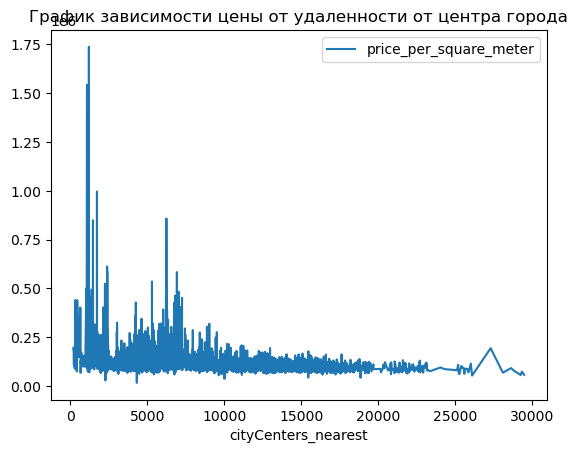

In [72]:
data.query('locality_name == "Санкт-Петербург"').pivot_table(index='cityCenters_nearest', \
values='price_per_square_meter',  aggfunc = 'median').plot(title='График зависимости цены от удаленности от центра города')
plt.show()

Рассмотрим величину корреляции с помощью коэффициента Пирсона. Корреляция составляет -0.2. Корреляция довольно слабая, но она есть. Также корреляция - отрицательная. Это значит, что чем дальше объект от центра города, тем цена ниже.

In [73]:
data['cityCenters_nearest'].corr(data['last_price'])

-0.2400111720835663

На графике мы видим, что цена остается высокой на расстоянии до 7000 м(7 км) от центра. Особый рост стоимости наблюдается у кватир, которые находятся в 1000/2000 м (1/2км) от центра. Это вполне логично, так как всегда стоимость жилья в центральных районах превышает стоимость в других районах города. Это связано с тем, что из центра удобно добираться в любую часть города, там очень развитая инфраструктура. Эти районы обычно лучше всего благоустроены, много развлечений находится в пешей доступности.
Далее на графике мы видим закономерный спад. Чем дальше от центра, тем ниже стоимость жилья. Это также логично, поскольку из отдаленных районов дольше добираться до работы, могут быть проблемы с общественным транспортом (например, отсутствие станции метро) или пробки на дорогах. Также отдаленные районы не всегда так хорошо благоустроены, как центральные. Там нет большого количества развлечений и мест для прогулок.

### Общий вывод

В данном проекте мы работали с входными данными от сервиса Яндекс Недвижимость, а именно с архивом объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах. Наша задача заключалась в том, чтобы выполнить предобработку данных и изучить их, чтобы найти интересные особенности и зависимости, которые существуют на рынке недвижимости.


На этапе предодобработки мы обнаружили и заполнили пропуски в данных о высоте потолков, жилой площади, апартаментах, площади кухни, балконах, названиях населенного пункта. Также были обнаружены пропуски в расстоянии до ближайшего аэропорта в метрах, расстоянии до центра города, числе парков в радиусе 3 км, расстоянии до ближайшего парка, числе водоёмов в радиусе 3 км, расстоянии до ближайшего водоёма. Данные в этих столбцах являются картографическими.Возможно, произошёл технический сбой, и эти данные не загрузились. Рекомендация: наладить получение картографических данных. Пропуски в столбце days_exposition могут быть связаны с тем, что объявление о продаже квартиры всё ещё остается на сайте, поэтому количество дней размещения неизвестно.
Также на этапе предобработки нами были найдены и обработаны строки с неявными дубликатами и аномальными значениями.


Далее нами был проведен исследовательский анализ данных, в ходе которого мы изучили такие параметры, как:
общая площадь;
жилая площадь;
площадь кухни;
цена объекта;
количество комнат;
высота потолков;
этаж квартиры;
тип этажа квартиры («первый», «последний», «другой»);
общее количество этажей в доме;
расстояние до центра города в метрах;
расстояние до ближайшего аэропорта;
расстояние до ближайшего парка;
день и месяц публикации объявления.


В ходе исследовательского анализа данных нами было сделаны следующие выводы:

1) Общая площадь.
БОльшая часть квартир имеют общую площадь от 35 м² до 120 м². Данные выглядят достоверными, поскольку чаще всего в объявлениях о продаже встречаются квартиры именно с такой площадью, так как они обычно являются оптимальными по цене и по площади для покупки семьями. Квартиры менее 35 м² встречаются реже, скорее всего это студии. Такой вид жилья не пользуется таким же большим спросом, так как он не подходит для семей. Максимальная общая площадь квартир составляет более 600 м², таких квартир немного, но они есть.

2) Жилая площадь.
Чаще всего жилая площадь в квартирах составляет от 20 до 75 м². Минимальная жилая площадь 12 м² встречается редко, так как такая жилая площадь может быть в очень маленькой студии. Такое жилье не пользуется спросом, поскольку подходит для 1 человека на недолгий период времени. Максимальные значения жилой площади достигают 350 м², но также являются довольно редкими, поскольку квартир с такой площадью не так много. В силу своей стоимости немногие могут позволить себе приобретение такого жилья.

3) Площадь кухни.
Показатели площади кухни являются аналогичными показателям общей и жилой площади. Чаще всего площадь кухни составляет от 7 до 20 м². Минимальный размер кухни составляет 4 м², такие кухни характерны для студий(если учитывать кухню без гостинной) и малогаборитных квартир. Довольно редкими явялются значения выше 60 м², так как такие кухни могут быть только в квартирах с довольно большой общей площадью. Как мы выяснили, такие объявления встречаются не очень часто.

4) Цена объекта.
Минимальные значения цены квартиры на момент снятия с публикации начинаются от 1500000 рублей, так может стоить маленькая студия в соседнем к Санкт-Петербургу населенном пункте. В среднем стоимость квартир состаляет от 4.5 до 8 миллинов рублей. Именно так стоят квартиры в Санкт-Петербурге и пригороде. Максимальная стоимость составляет 763000000. 

5) Количество комнат.
В основном продаются 1-комнатные и 2-комнатные квартиры, немного меньше продается 3-комнатных квартир, но их доля также довольно большая. Меньше всего продается 6 и 7-комнатных квартир, так как такие квартиры встречаются довольно редко и имеют большую общую и жилую площадь. 

6) Высота потолков.
В среднем высота потолков составляет 2.7 м. Такая высота потолков считается стандартной и встречается чаще всего. Есть несколько квартир с потолками от 2.4 до 2.7 м, но это довольно редкие случаи. Самые большая высота потолков достигает 6м, но также встречается не часто.

7) Этаж квартиры.
Самые часто встречающиеся этажи в проданных квартирах - с 1 по 4. Квартир на 5-ом этаже меньше. Это можно обосновать тем, что большое количество жилья продавалось в том числе в старой 5-этажной застройке. Обычно люди менее охотно покупают жилье на последнем этаже, особенно в старых домах, так как квартиры на последних этажах могут иметь непредвиденные проблемы (например, проблемы с крышей). Чем выше этаж, тем меньше квартир представлено. Причина заключается в том, что на данный момент большая часть застройки в Питере и пригороде относится к старому жилищному фонду, который обычно имеет не более 9-ти этажей.

8) Тип этажа квартиры.
Доля проданных квартир на 1-ом и последнем этажах примерно одинаковая. Это объясняется тем, что на этих этажах люди менее охотно покупают недвижимость. На 5-ом этаже могут быть проблемы с крышей или неудобство при отсутствии лифта, а на первом неприятный запах из подвала, близость кафе или магазинов (в которых могут быть крысы или тараканы), шум с улицы, отсутствие балконов.

9) Общее количество этажей в доме.
Большая часть жилья имеет до 9 этажей. Это можно обосновать тем, что в основном старый жилой фонд имеет такую этажность. Максимальное количество этажей в доме - 36. Такая этажность может быть в современных многоэтажках.

10) Расстояние до центра города в метрах.
В среднем расстояние до центра города от квартир составляет 15000м (15 км). Минимальное расстояние до центра составляет 181 м, а максимальное 66000м (66км).

11) Расстояние до ближайшего аэропорта.
В среднем расстояние до аэропорта составляет от 15000 до 50000м (15 до 50 км). Однако есть квартиры, которые расположены ближе, в 5-10 км, что может доставить определенные неудобства (например, шум). Некоторые квартиры находятся очень далеко от аэропорта, максимальное расстояние составляет 85000м(85км).

12) Расстояние до ближайшего парка.
В среднем квартиры находятся в 300-1000 м от парка, что является пешей доступностью. Большая доля квартир находится на расстоянии от 1000 до 2500м. Всего несколько квартир находятся в 3000 м от парка.

13) День и месяц публикации объявления.
Доля объявлений, опубликованных в будние дни (0-4), выше, чем в выходные (5-6). 
Самыми популярными месяцами для публикации объявлений о продаже квартиры являются октябрь, ноябрь, март, апрель, февраль. В эти месяцы нет долгих праздников или других сезонных событий. Менее популярные месяцы - декабрь (люди готовятся к праздникам) январь (зимние каникулы/праздники), май (майские праздники), все летние месяцы (так как многие уезжают на море, в деревню), сентябрь (начало учебного года).



В ходе исследования нам удалось установить следующие особенности и зависимости, которые существуют на рынке недвижимости в Санкт-Петербурге:

1.В среднем продажа квартиры занимает от 90 до 200 дней (от 3 до 6 месяцев). Продажи за месяц или полтора (30-45 дней) можно считать быстрыми, а продажи, которые длятся 3-4 года (1500 дней) можно считать очень долгими.

2.Есть зависимость между стоимостью квартиры и её общей площадью, жилой площадью и площадью кухни. Чем больше площади, тем выше стоимость объекта.

3.Также существует корреляция между стоимостью жилья и количеством комнат в квартире: чем больше комнат в квартире, тем выше ее стоимость, однако связь с данным фактором есть не всегда.

4.Есть зависимость между типом этажа квартиры и её стоимостью. Самая низкая стоимость у квартир на 1-ом этаже, так как они являются не очень популярным вариантом для покупки по ряду причин: неприятный запах из подвала, близость кафе или магазинов (в которых могут быть крысы или тараканы), шум с улицы, отсутствие балконов. Самая высокая стоимость наблюдается у квартир на последнем этаже. Это может быть связано с ценой на пентхаусы, которые находятся на последних этажах и обычно очень дорого стоят. Также в новостройках люди могут покупать жилье на последнем этаже, так как там может быть красивый вид.

5.Также наблюдается зависимость между днем и месяцем размещения объявления. самая высокая стоимость у квартир, которые продаются по субботам. Возможно это связано с тем, что в выходной день люди более охотно идут на серьезные сделки, так как они в лучшем расположении духа. В пятницу наблюдается сильный спад в цене. Это может быть связано с тем, что в пятницу люди менее охотно идут на сделки из-за усталости. Самая высокая цена наблюдается в апреле, сентябре и декабре. В январе, феврале, в летние месяцы и октябре наблюдается спад. Это может быть связано с различными сезонными событиями и праздниками.
Также есть связь цены с годом, так после 2014 года цены на жилье начали постепенно снижаться. Это произошло после вступления Крыма в Россию, а затем в 2018 году цены снова начали рости, возможно, после чемпиона мира по футболу, который прошёл в России.

Также был проведён расчет средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Населенный пункт с самой высокой стоимостью квадратного метра - это посёлок Репино. 
Населенный пункт с самой низкой стоимостью квадратного метра - это Бокситогорск. 


Кроме того, был проведен расчёт средней цены объкта в зависимости от расстояния до центра города. Цена остается высокой на расстоянии до 7000 м(7 км) от центра. Особый рост стоимости наблюдается у квартир, которые находятся в 1000/2000 м (1/2км) от центра. Это вполне логично, так как всегда стоимость жилья в центральных районах превышает стоимость в других районах города. Это связано с тем, что из центра удобно добираться в любую часть города, там очень развитая инфраструктура. Эти районы обычно лучше всего благоустроены, много развлечений находится в пешей доступности.
Закономерный спад наблюдается в стоимости жилья, которое довольно далеко от центра.
Это можно обосновать тем, что из отдаленных районов дольше добираться до работы, могут быть проблемы с общественным транспортом (например, отсутствие станции метро) или пробки на дорогах. Также отдаленные районы не всегда так хорошо благоустроены, как центральные. Там нет большого количества развлечений и мест для прогулок.

    
Таким образом, на основании проведенного исследования мы выявили ряд закономерностей и особенностей, которые существуют на рынке недвижимости в Санкт-Петербурге.
    